In [30]:

# 修改了聊天模板，增加聊天记录


In [31]:
from typing import Literal,Annotated, TypedDict, Union

from langchain_core.tools import tool
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage

from langchain_core.agents import AgentAction, AgentFinish
import operator

from langgraph.graph import END, START,StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import ToolExecutor, ToolInvocation
from tools_helper import *
from langchain.agents import create_react_agent 
from langchain_core.pydantic_v1 import BaseModel



In [32]:

tool=search


In [33]:
# 工具绑定
tools= [search,weather,data_process]
tool_executor = ToolExecutor(tools)
prompt = react_chat_prompt() # 创建聊天的模板
model_with_tools   = create_react_agent(model, tools, prompt)
def run_agent(state):
    agent_outcome = model_with_tools.invoke(state)
    return {"agent_outcome": agent_outcome }

In [34]:
# 创建一个状态
class AgentState(TypedDict):
    
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]


In [35]:
# 运行工具节点
def execute_tools(state):
    messages = [state["agent_outcome"]]
    last_message = messages[-1]
    tool_name = last_message.tool
    tool_input = last_message.tool_input
    action = ToolInvocation(
        tool=tool_name,
        tool_input= tool_input
    )
    response = tool_executor.invoke(action)
    return {"intermediate_steps": [(state["agent_outcome"], response)]}


In [36]:
graph = StateGraph(AgentState)
# 增加一个chatbot节点，具有工具调用功能
graph.add_node("chatbot", run_agent)
# 工具节点

graph.add_node("tools", execute_tools)
#增加一条边，从开始到chatbot，
graph.set_entry_point("chatbot")    
# 增加一条边，从工具回到chatbot，
graph.add_edge("tools", "chatbot")

In [37]:
# 从chatbot 发出一条条件边，根据情况到达工具节点或结束
def router(state):
    messages = [state["agent_outcome"]]
    last_message = messages[-1]

    if "Action"  in last_message.log:
        return "tools"
    else:
        return END
graph.add_conditional_edges("chatbot", router)

In [38]:
graph_runner = graph.compile()

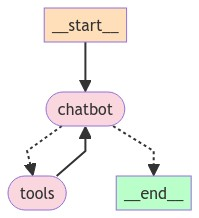

In [39]:
display(graph_runner)

In [40]:

# 添加聊天记录
chat_history = []
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    trytime=3 #出错尝试3次
    while trytime>0:
        try:
            output= graph_runner.invoke({"input": user_input,"chat_history":chat_history})
            answer= output['agent_outcome'].log.split('Final Answer')[1]
            print("answer",answer)
            chat_history.append({'role':'user',"content":user_input})
            chat_history.append({'role':'assistant',"content":answer})
            break
        except Exception as e:
            print(e)
            trytime-=1
            print("Try again!")

answer : 苏州的天气情况如下：温度为28°C（82°F），湿度为65%，风向为东南（SE），风速为每小时15公里（每小时10英里）。全天晴朗，无降雨。
Goodbye!


In [41]:
# snapshot=graph_runner.get_state(config)